### ***Автоматическое распознавание эмоциональной окраски речи***

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions-dataset-for-nlp


In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv(path + '/train.txt', sep=';', header = None, names = ['text', 'emotion'])

In [ ]:
train

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
X = train['text']
y = train['emotion']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

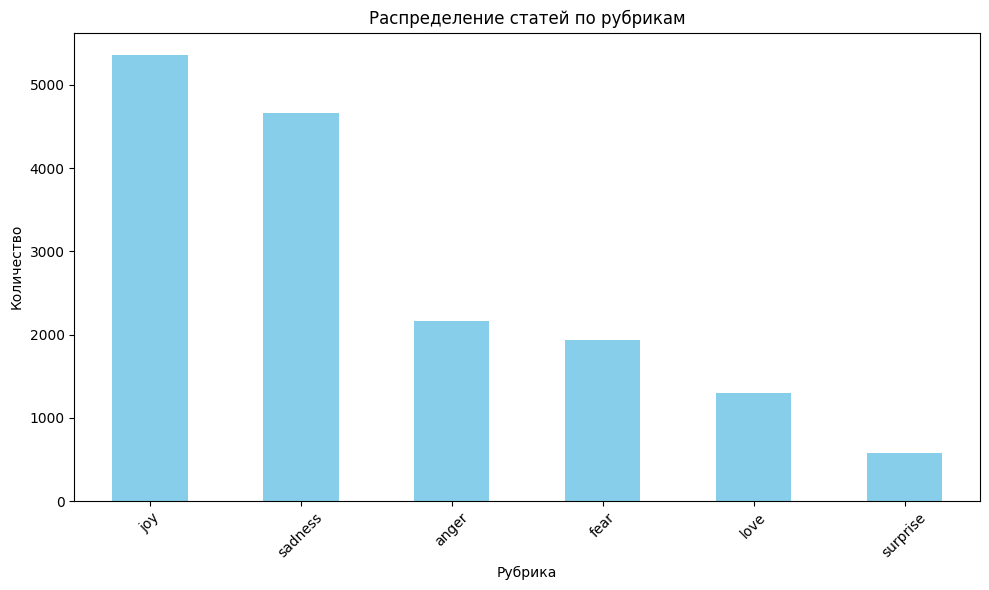

In [ ]:
plt.figure(figsize=(10, 6))
train['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение статей по рубрикам')
plt.xlabel('Рубрика')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
le = LabelEncoder()
train['emotion_encoded'] = le.fit_transform(train['emotion'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [ ]:
X_train, X_test, y_train_tfidf, y_test_tfidf = train_test_split(train['text'], train['emotion_encoded'], test_size=0.2, random_state=42)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
model_catboost = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    depth=3,
    eval_metric='Accuracy',
    task_type='GPU',
    devices='0:1',
    random_seed=42,
    early_stopping_rounds=200,
    verbose=500,
)

In [ ]:
train_pool_tfidf = Pool(X_train_tfidf, y_train_tfidf)
valid_pool_tfidf = Pool(X_test_tfidf, y_test_tfidf)

In [ ]:
model_catboost.fit(
    train_pool_tfidf,
    eval_set=valid_pool_tfidf,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2206736	test: 0.2044099	best: 0.2044099 (0)	total: 38.8ms	remaining: 6m 27s
500:	learn: 0.8858653	test: 0.8709383	best: 0.8709383 (496)	total: 6.79s	remaining: 2m 8s
1000:	learn: 0.9251724	test: 0.9020233	best: 0.9030685 (923)	total: 19s	remaining: 2m 51s
bestTest = 0.9037804821
bestIteration = 1225
Shrink model to first 1226 iterations.


In [ ]:
y_pred_cat_tfidf = model_catboost.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_cat_tfidf, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.88      0.89      0.88       427
        fear       0.86      0.85      0.86       397
         joy       0.93      0.88      0.90      1021
        love       0.73      0.95      0.82       296
     sadness       0.97      0.88      0.93       946
    surprise       0.65      0.97      0.78       113

    accuracy                           0.89      3200
   macro avg       0.84      0.90      0.86      3200
weighted avg       0.90      0.89      0.89      3200



In [ ]:
num_labels = train["emotion_encoded"].nunique()
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train["text"].tolist(), train["emotion_encoded"].tolist(), test_size=0.2, random_state=42
)

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class EmotionsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionsDataset(train_texts, train_labels)
test_dataset = EmotionsDataset(test_texts, test_labels)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

loss_values = []
epoch_avg_losses = []
best_loss = float('inf')
no_improve_steps = 0
early_stop_patience = 300

model.train()

stop_training = False

for epoch in range(1, 100):
    if stop_training:
        break

    loop = tqdm(train_loader, desc=f"Эпоха {epoch}")
    epoch_losses = []
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_val = loss.item()
        epoch_losses.append(loss_val)
        loss_values.append(loss_val)
        loop.set_postfix(loss=loss_val)


        if loss_val < best_loss - 1e-4:
            best_loss = loss_val
            no_improve_steps = 0
        else:
            no_improve_steps += 1

        if no_improve_steps >= early_stop_patience:
            print(f"\n📉 Ранняя остановка на эпохе {epoch} — без улучшения {early_stop_patience} батчей.")
            stop_training = True
            break


    epoch_avg_loss = np.mean(epoch_losses)
    epoch_avg_losses.append(epoch_avg_loss)


Эпоха 3:  50%|████▉     | 399/800 [02:03<02:03,  3.24it/s, loss=0.218]


📉 Ранняя остановка на эпохе 3 — без улучшения 300 батчей.


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

In [ ]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.94      0.88      0.91       427
        fear       0.91      0.86      0.88       397
         joy       0.94      0.94      0.94      1021
        love       0.82      0.91      0.86       296
     sadness       0.96      0.95      0.96       946
    surprise       0.74      0.94      0.82       113

    accuracy                           0.92      3200
   macro avg       0.88      0.91      0.90      3200
weighted avg       0.93      0.92      0.92      3200

